To be run in CMSSW_10_2_3 with adding:
pip install --user joblib scikit-learn==0.20.4

In [1]:
Mjj_selection = 800.

vae_loss = 'mse_190806'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-3]/x[:,1]+x[:,-2]/x[:,6]
    out *= 1e8
    return out

# def computeDiscriminatingVar(x):
#     out = x[:,-2]+x[:,-1]
#     return out*1e4

# Imports

In [2]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.12/07


# Get the discrimination on the side-band

In [4]:
file_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/AE_Score/'
maxEvts = int(5e6)
# pb = ProgressBar(maxEvts)

# data_side = None
# for tag in ['EXT', 'EXT2']:
#     name_tag = 'qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND_' + tag
#     flist = glob(file_dir + name_tag + '/' + name_tag + '_*.h5')
#     for fname in flist:
#         f = h5py.File(fname, 'r')
#         aux_evts = np.array(f.get('data'))
#         aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
#         if data_side is None:
#             print('Labels:')
#             print(list(f.get('labels')))
#             raise
#             pb.show(0)
#             data_side = aux_evts
#         else:
#             data_side = np.append(data_side, aux_evts, axis=0)
        
#         pb.show(data_side.shape[0])

#         if data_side.shape[0] > maxEvts:
#             break
#     if data_side.shape[0] > maxEvts:
#         break

In [ ]:
# pickle.dump(data_side, open(file_dir + 'tmp_qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND_MIAD.pkl', 'wb'))

In [6]:
data_side = pickle.load(open(file_dir + 'tmp_qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND_MIAD.pkl', 'rb'))

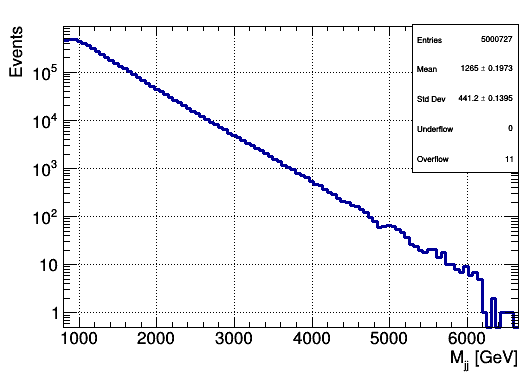

In [7]:
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, 0.8*np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [8]:
# Compute weights to make it mass agnostic
hM = h_Mjj_side.Clone('hM')
print(hM.FindBin(10000))
scale = np.sqrt(hM.GetMaximum()*hM.GetMinimum(0))
print(scale)
hM.Scale(1./scale)

weights = np.ones_like(data_side[:,0])
for i, m in enumerate(data_side[:,0]):
    weights[i] = 1./hM.GetBinContent(hM.FindBin(m))
    if i%1000000 == 0:
        print(i)

101
694.3658977801257
0
1000000
2000000
3000000
4000000
5000000


In [15]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=5,
                                tol=1e-6,
                                verbose=2)

x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
gbr_cut.fit(x, y, sample_weight=None);

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

      Iter       Train Loss   Remaining Time 
         1           0.7613           15.13m
         2           0.7608           14.45m
         3           0.7604           14.22m
         4           0.7601           13.81m
         5           0.7598           13.49m
         6           0.7596           13.47m
         7           0.7594           12.87m
         8           0.7593           12.48m
         9           0.7592           12.57m
        10           0.7591           12.33m
        11           0.7590           12.37m
        12           0.7589           12.27m
        13           0.7589           12.32m
        14           0.7588           12.11m
        15           0.7588           11.97m
        16           0.7588           12.13m
        17           0.7587           11.93m
        18           0.7587           11.73m
        19           0.7587           11.65m
        20           0.7587           11.64m
        21           0.7586           11.44m
        2

['../models/gbr_cut_trained_20190913.joblib']

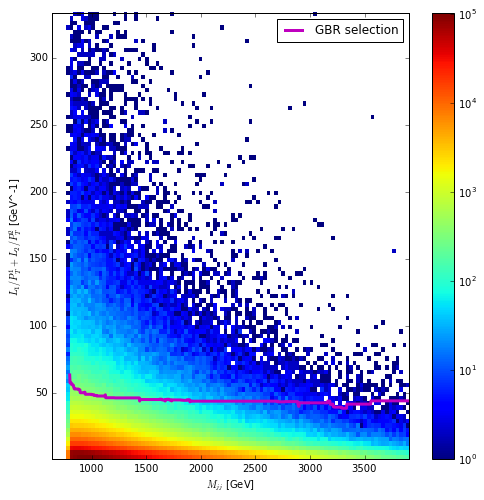

In [16]:
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.9)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [12]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [13]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

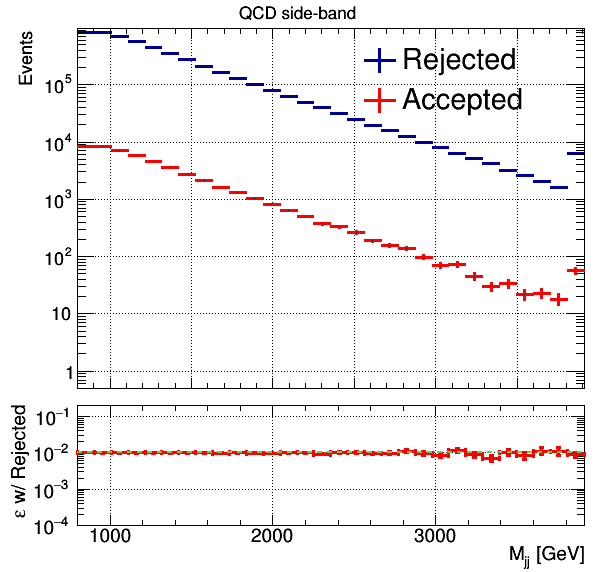

In [17]:
x = x.flatten()
binning=[30, Mjj_selection, np.percentile(x, 99.9)]

sel = getSelection(x, y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD side-band')
h_a = c.h_list[1]
h_r = c.h_list[0]

# Define and test Hypotesis test

In [18]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=False):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs)
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')

    return p_val

In [19]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

S obs: 128.03084845762336
Test stat reached after 1 loops


0.8452

# Analyze signal region

In [34]:
sample_loc = {'qcd':'qcd_sqrtshatTeV_13TeV_PU40',
#               'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV',
#               'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
#               'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':r'QCD',
                'AtoZZZ':r'$A\to ZZZ$',
                'GtoWW':r'$G\to WW$',
                'GtoBtt':r'$G_{B}\to t\bar{t}$',
                'GtoNtt':r'$G_{N}\to t\bar{t}$'
               }

sample_label_ROOT = {'qcd':'QCD',
                'AtoZZZ':'A #rightarrow ZZZ',
                'GtoWW':'G #rightarrow WW',
                'GtoBtt':'G_{B} #rightarrow t#bar{t}',
                'GtoNtt':'G_{N} #rightarrow t#bar{t}'
               }

SM_samples = ['qcd']
BSM_samples = ['GtoWW'] #, 'AtoZZZ', 'GtoBtt', 'GtoNtt']

sample_nGenEvts = {'qcd': 1990*10000,
#                    'AtoZZZ': 100*1000,
                   'GtoWW': 92*10000,
#                    'GtoBtt': 96*1000,
#                    'GtoNtt': 96*1000
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

In [31]:
lumi_generated = sample_nGenEvts['qcd']/sample_xsec['qcd']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 2278.5 pb^-1


### Get the data

In [35]:
# data = {}
# sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, name_tag in sample_loc.iteritems():
    print(n)
    if not n == 'qcd':
        flist = glob(file_dir + name_tag + '/' + name_tag + '_*.h5')
        x = None
        pb = ProgressBar(len(flist))
        for i, fname in enumerate(flist):
            pb.show(i)
            f = h5py.File(fname, 'r')
            aux_evts = np.array(f.get('data'))
            aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
            if x is None:
                x = aux_evts
            else:
                x = np.append(x, aux_evts, axis=0)

        # apply the dijet mass cut
        dVar = computeDiscriminatingVar(x)
        sel = getSelection(x[:,0], dVar)
        x = np.column_stack((x, dVar, sel))
        print(x.shape[0])
        sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]

        dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
        dt += [('sel', '?')]
        data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

GtoWW
[####################]  100% - Tot. time: 4.4 s
523674
qcd
+--------+----------+--------------+---------------+-------------+
| Sample | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+--------+----------+--------------+---------------+-------------+
| GtoWW  |  523674  |     56.9     |      9389     |     1.79    |
|  qcd   | 5824577  |     29.3     |     32806     |     0.56    |
+--------+----------+--------------+---------------+-------------+


### Define utilitities

In [36]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [41]:
lumi = 2000 #pb^-1

N_asymov = 10000
N_exp_per_xsec = 10

In [42]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



GtoWW
xsec BSM 1.0e-05 pb
Experiment: 0
S obs: 274.2535646850704
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 1
S obs: 269.3657980409225
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 2
S obs: 282.1683910958248
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 3
S obs: 277.65716869545815
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 4
S obs: 290.1526775908174
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 5
S obs: 289.5861527854626
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 6
S obs: 251.8603753770188
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never 

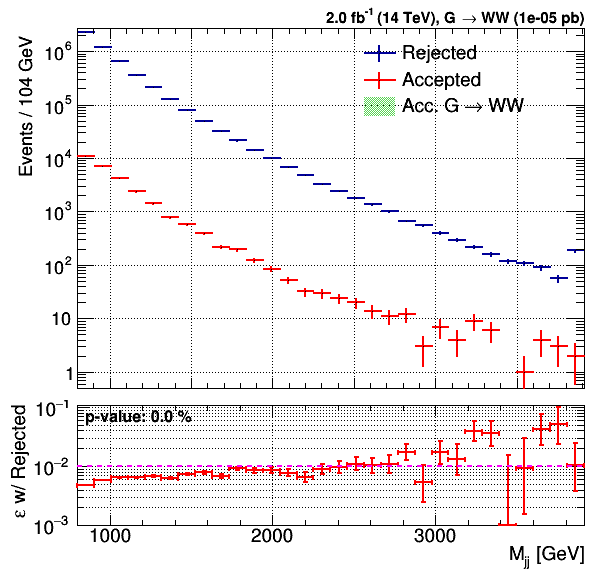

In [43]:
for name_BSM in BSM_samples:
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    for xsec_BSM in np.logspace(-5, -4, 1): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
                d_obs = np.concatenate((d_obs, d_aux))

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow'
                                )

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow'
                                    )
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = '../fig/ModelIndependentAnalysis_v2/massSpectrum/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                c.SaveAs(fig_name + '.png')

        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)

# Make the p-value plot

In [44]:
sample_col = {
              'AtoZZZ':'r',
              'GtoWW':'b',
              'GtoBtt':'g',
              'GtoNtt':'c'
             }

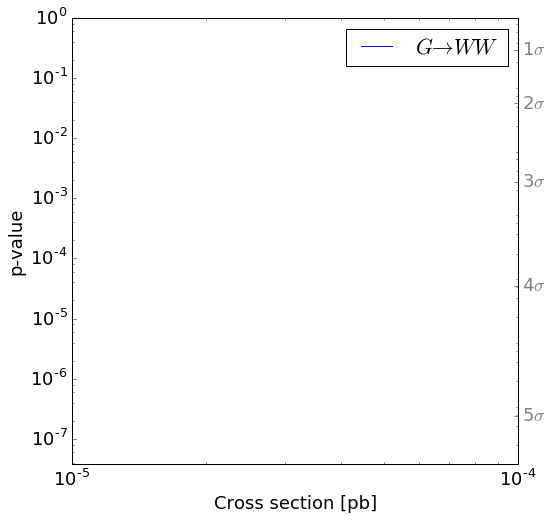

In [45]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('../fig/ModelIndependentAnalysis_v2/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')